In [1]:
import pandas as pd 
import numpy as np 
import cv2
import PIL
import matplotlib.pyplot as plt 
from matplotlib import cm
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import regularizers
from tensorflow.keras.utils import model_to_dot, plot_model

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report

#from IPython.display import Image, display # for Grad-CAM
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

In [16]:
# read information data
List_Benign = pd.read_csv('mini_DDSM/List_Benign.csv')
List_Malignant = pd.read_csv('mini_DDSM/List_Cancer.csv')
List_Normal = pd.read_csv('mini_DDSM/List_Normal.csv')

print(List_Benign.shape) #3360 images
print(List_Malignant.shape) #3596 images
print(List_Normal.shape) #2728 images
List_Benign.head()

(3360, 4)
(3596, 4)
(2728, 4)


,View,fileName,Age,Density
0,RMLO,1_C_0029_1.RIGHT_MLO.LJPEG.1_highpass.png,66,3
1,LMLO,2_C_0029_1.LEFT_MLO.LJPEG.1_highpass.png,66,3
2,RCC,3_C_0029_1.RIGHT_CC.LJPEG.1_highpass.png,66,3
3,LCC,4_C_0029_1.LEFT_CC.LJPEG.1_highpass.png,66,3
4,RMLO,5_C_0033_1.RIGHT_MLO.LJPEG.1_highpass.png,60,3


In [17]:
List_Benign["path"] = "/" + List_Benign["fileName"]
List_Malignant["path"] = "/" + List_Malignant["fileName"]
List_Normal["path"] = "/" + List_Normal["fileName"]

List_Benign["path"] = List_Benign["path"].apply(lambda x: x.replace('/', "mini_DDSM/Benign/"))
List_Malignant["path"] = List_Malignant["path"].apply(lambda x: x.replace('/', "mini_DDSM/Cancer/"))
List_Normal["path"] = List_Normal["path"].apply(lambda x: x.replace('/', "mini_DDSM/Normal/"))

List_Benign["class"] = "Benign"
List_Malignant["class"] = "Malignant"
List_Normal["class"] = "Normal"

# After inspections, we will use RCC(RIGHT CC view mammogram due to it has less number of images)
List_Benign = List_Benign[List_Benign["View"] == "RCC"]
List_Malignant = List_Malignant[List_Malignant["View"] == "RCC"]
List_Normal = List_Normal[List_Normal["View"] == "RCC"]

print(List_Benign.shape)  #notice that class are imbalenced
print(List_Malignant.shape)
print(List_Normal.shape)

List_Benign = List_Benign.sample(n = 400)
List_Malignant = List_Malignant.sample(n = 400)
List_Normal = List_Normal.sample(n = 400)

df = pd.concat([List_Benign, List_Malignant, List_Normal], ignore_index=True)
df["class"] = df["class"].map({"Normal":0, "Benign":1, "Malignant":2})
df = df.sample(frac=1).reset_index(drop=True) #shuffle the data
print("final size: ", df.shape)
print(df["class"].value_counts())
df.head(10)

(407, 6)
(487, 6)
(785, 6)
final size:  (1200, 6)
2    400
0    400
1    400
Name: class, dtype: int64


,View,fileName,Age,Density,path,class
0,RCC,2103_B_3006_1.RIGHT_CC.LJPEG.1_highpass.png,48,4,mini_DDSM/Cancer/2103_B_3006_1.RIGHT_CC.LJPEG.1_highpass.png,2
1,RCC,1620_A_0610_1.RIGHT_CC.LJPEG.1_highpass.png,73,2,mini_DDSM/Normal/1620_A_0610_1.RIGHT_CC.LJPEG.1_highpass.png,0
2,RCC,1964_D_4583_1.RIGHT_CC.LJPEG.1_highpass.png,52,2,mini_DDSM/Normal/1964_D_4583_1.RIGHT_CC.LJPEG.1_highpass.png,0
3,RCC,2479_D_4169_1.RIGHT_CC.LJPEG.1_highpass.png,51,4,mini_DDSM/Benign/2479_D_4169_1.RIGHT_CC.LJPEG.1_highpass.png,1
4,RCC,3135_C_0509_1.RIGHT_CC.LJPEG.1_highpass.png,42,3,mini_DDSM/Benign/3135_C_0509_1.RIGHT_CC.LJPEG.1_highpass.png,1
5,RCC,399_C_0068_1.RIGHT_CC.LJPEG.1_highpass.png,48,2,mini_DDSM/Cancer/399_C_0068_1.RIGHT_CC.LJPEG.1_highpass.png,2
6,RCC,3239_B_3485_1.RIGHT_CC.LJPEG.1_highpass.png,42,3,mini_DDSM/Benign/3239_B_3485_1.RIGHT_CC.LJPEG.1_highpass.png,1
7,RCC,864_A_0317_1.RIGHT_CC.LJPEG.1_highpass.png,53,4,mini_DDSM/Normal/864_A_0317_1.RIGHT_CC.LJPEG.1_highpass.png,0
8,RCC,3359_B_3468_1.RIGHT_CC.LJPEG.1_highpass.png,50,3,mini_DDSM/Benign/3359_B_3468_1.RIGHT_CC.LJPEG.1_highpass.png,1
9,RCC,263_B_3082_1.RIGHT_CC.LJPEG.1_highpass.png,50,4,mini_DDSM/Cancer/263_B_3082_1.RIGHT_CC.LJPEG.1_highpass.png,2


<AxesSubplot:title={'center':'training class are imbalanced(only right breast CC images)'}, ylabel='counts'>

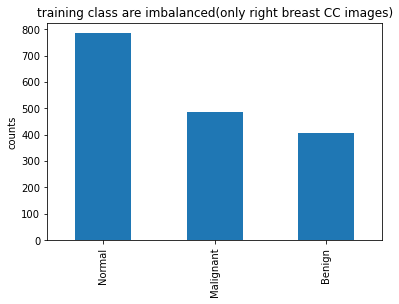

In [8]:
#check the class balances
df["class"].value_counts().plot(kind = "bar", ylabel = "counts", title = "training class are imbalanced(only right breast CC images)")

1200
1200


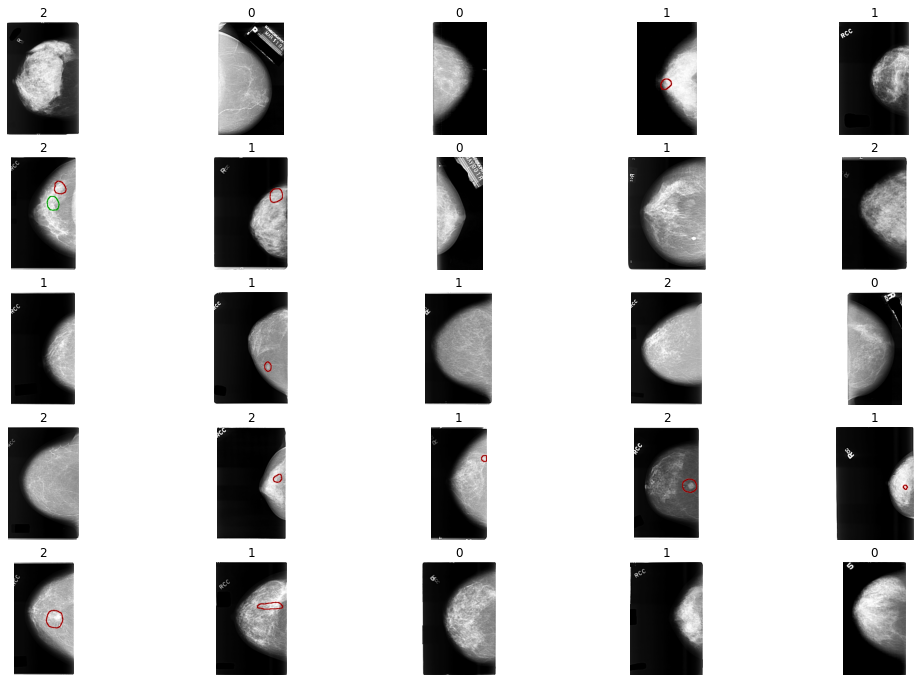

In [18]:
X = []
Y = df["class"]

for file in df["path"]:
    img = cv2.imread(file)
    #img = tf.image.resize_with_pad(img, 64, 64) / 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)
    
print(len(X))
print(len(Y))
fig = plt.figure(figsize=[18, 12])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(X[i], cmap=plt.get_cmap(None))
    ax.set_title(Y[i])
    ax.axis('off')

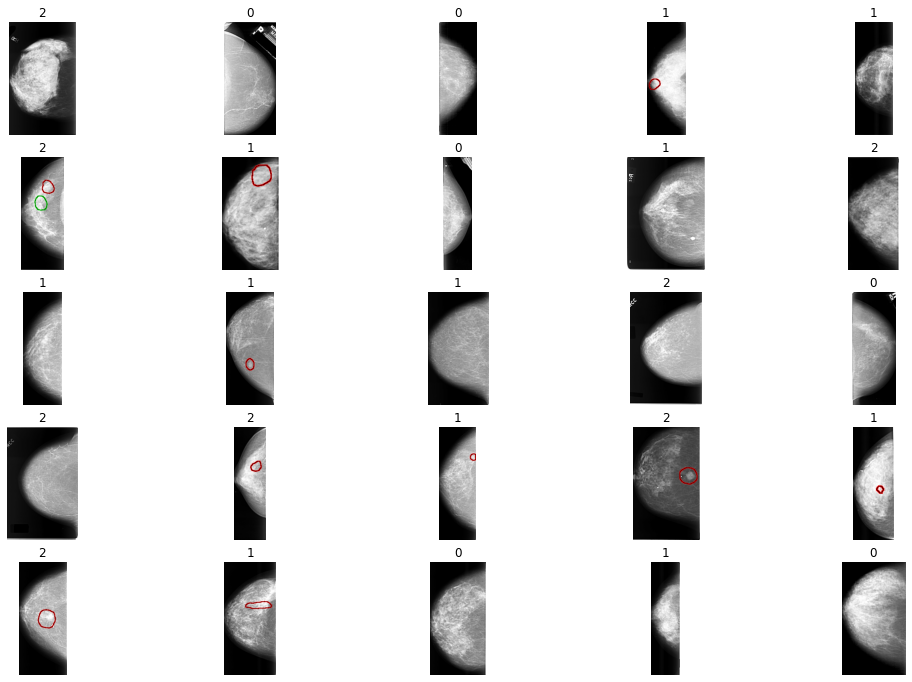

In [19]:
# crop images by using findContours and have a sanity check. You can see some black empty spaces has been removed, this can reduce some data noise.

lower = np.array([60, 60, 60])
upper = np.array([250, 250, 250])

cont_img_list = []
mask_img_list = []
cropped_image = []
for img in X:
    copy_img = img.copy()
    mask_img = cv2.inRange(img, lower, upper)
    mask_img_list.append(mask_img)
    contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cont_img = cv2.drawContours(img, contours, -1, 255, 3)
    cont_img_list.append(cont_img)
    max_contour = max(contours, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    rec_img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),5)
    cropped = copy_img[y:y+h, x:x+w]
    cropped_image.append(cropped)

#plt.imshow(cropped_image[0])
fig = plt.figure(figsize=[18, 12])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(cropped_image[i], cmap=plt.get_cmap(None))
    ax.set_title(Y[i])
    ax.axis('off')

In [20]:
# Normalise and resize the images.
nor_img = []
for img in cropped_image:
    img = cv2.resize(img, (256, 256))
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    nor_img.append(img)

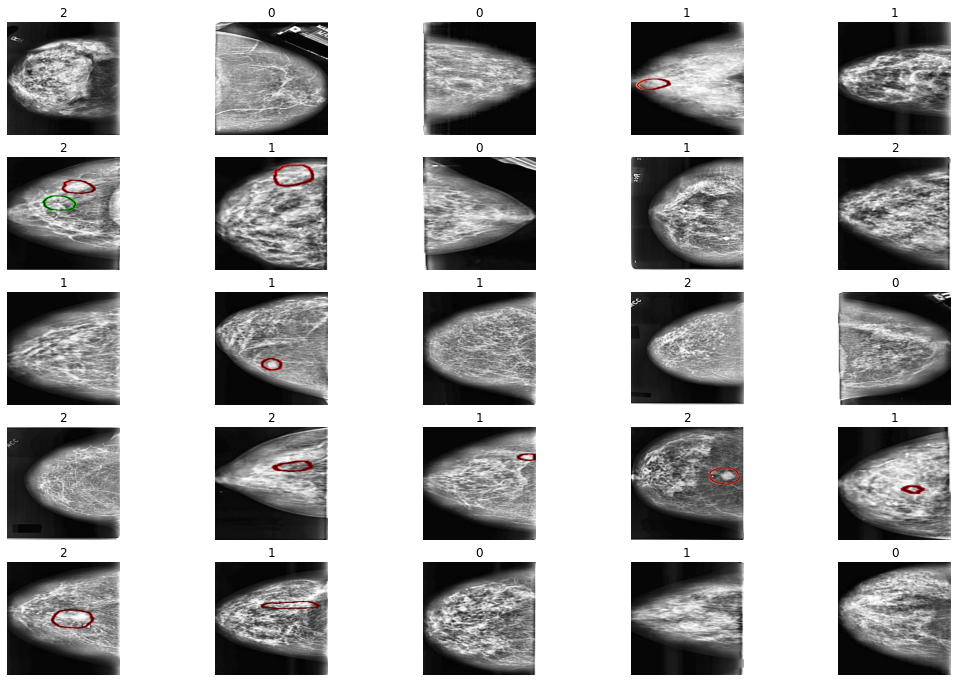

In [21]:
# use contrast limited adaptive histogram equalization (CLAHE) to enhance the details in the images.
# here we generate two image datasets, one with clipLimit=2.0 and clipLimit=3.0 to compare the difference.
clahe_img = []

for img in nor_img:
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
    cimg = cv2.cvtColor(img_lab, cv2.COLOR_Lab2RGB)
    clahe_img.append(cimg)
    
fig = plt.figure(figsize=[18, 12])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(clahe_img[i], cmap=plt.get_cmap('Greys'))
    ax.set_title(Y[i])
    ax.axis('off')

In [22]:
# train test split, here we use CLAHE(clipLimit=2.0) enhanced images to do the prediction. 
from sklearn.model_selection import train_test_split

x = np.array(clahe_img)
y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(840, 256, 256, 3)
(840,)
(360, 256, 256, 3)
(360,)


In [24]:
# create an VGG style back propagation neural network(training: 360, 128, 128, 3)(testing: 155, 128, 128, 3)
# use batchnorm and dropout to against overffiting
# predicting value is either 0 or 1(0 = normal, 1 = cancer)

inputs = keras.Input(shape=(256, 256, 3), name='images')

x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation=None)(x)
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='model')
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 8)       584       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 8)      32        
 hNormalization)                                                 
                                                                 
 spatial_dropout2d_5 (Spatia  (None, 256, 256, 8)      0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 8)      0     

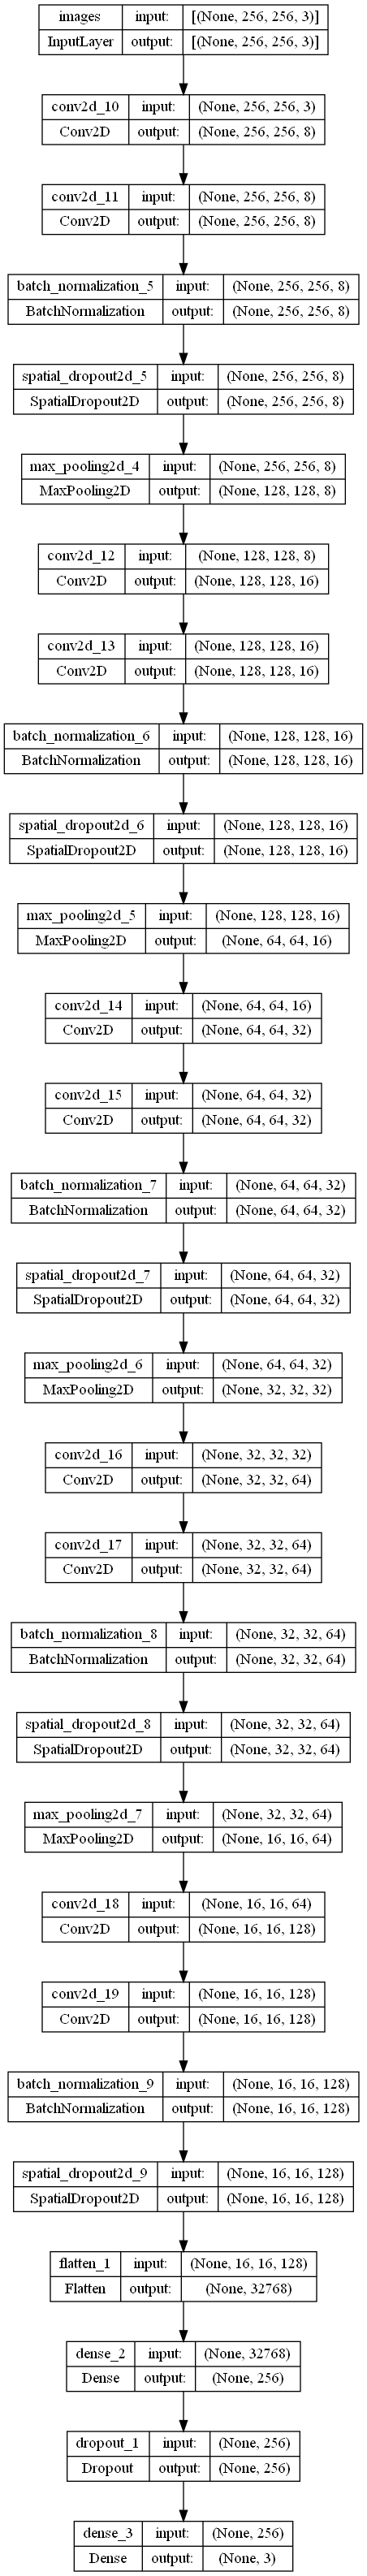

In [25]:
keras.utils.plot_model(model_cnn, show_shapes=True, to_file='model_str.png')

In [11]:
# train the model
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                  metrics=['accuracy'])
history = model_cnn.fit(X_train, Y_train,
                        batch_size=12,
                        epochs=45,
                        validation_data=(X_test, Y_test))

Epoch 1/45
53/53 [==============================] - 10s 92ms/step - loss: 1.1946 - accuracy: 0.5071 - val_loss: 1.0124 - val_accuracy: 0.4694
Epoch 2/45
53/53 [==============================] - 4s 71ms/step - loss: 0.9660 - accuracy: 0.5857 - val_loss: 1.0786 - val_accuracy: 0.3333
Epoch 3/45
53/53 [==============================] - 4s 72ms/step - loss: 0.8860 - accuracy: 0.6048 - val_loss: 1.0611 - val_accuracy: 0.3667
Epoch 4/45
53/53 [==============================] - 4s 71ms/step - loss: 0.9154 - accuracy: 0.5821 - val_loss: 0.9786 - val_accuracy: 0.3694
Epoch 5/45
53/53 [==============================] - 4s 71ms/step - loss: 0.8888 - accuracy: 0.6000 - val_loss: 0.9516 - val_accuracy: 0.4306
Epoch 6/45
53/53 [==============================] - 4s 70ms/step - loss: 0.8248 - accuracy: 0.6226 - val_loss: 0.9111 - val_accuracy: 0.4694
Epoch 7/45
53/53 [==============================] - 4s 72ms/step - loss: 0.8340 - accuracy: 0.6071 - val_loss: 0.9373 - val_accuracy: 0.4639
Epoch 8/45
5

12/12 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

     Normal        0.85      0.82      0.83       120
      Benign       0.55      0.53      0.54       120
   Malignant       0.52      0.56      0.54       120

    accuracy                           0.64       360
   macro avg       0.64      0.64      0.64       360
weighted avg       0.64      0.64      0.64       360

12/12 [==============================] - 0s 22ms/step


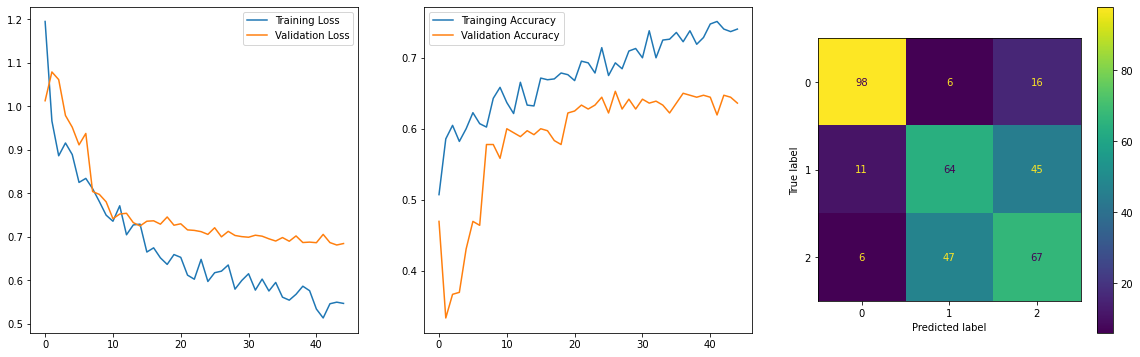

In [12]:
# measure model performance
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['accuracy'], label="Trainging Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend();

target_names = ['Normal ', 'Benign', "Malignant"]
pred = np.argmax(model_cnn.predict(X_test), axis=-1)
report = classification_report(Y_test, pred, target_names=target_names)
print(report)

#confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, np.rint(pred))
#ax = fig.add_subplot(1, 3, 3)
#c = ConfusionMatrixDisplay(confusion_matrix, display_labels = target_names)
#c.plot(ax = ax)

pred = model_cnn.predict(X_test)
indexes = tf.argmax(pred, axis=1)
confusionMatrix = confusion_matrix(Y_test, indexes)
ax = fig.add_subplot(1, 3, 3)
c = ConfusionMatrixDisplay(confusionMatrix, display_labels=range(3))
c.plot(ax = ax)

In [13]:
# new Grad-CAM
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

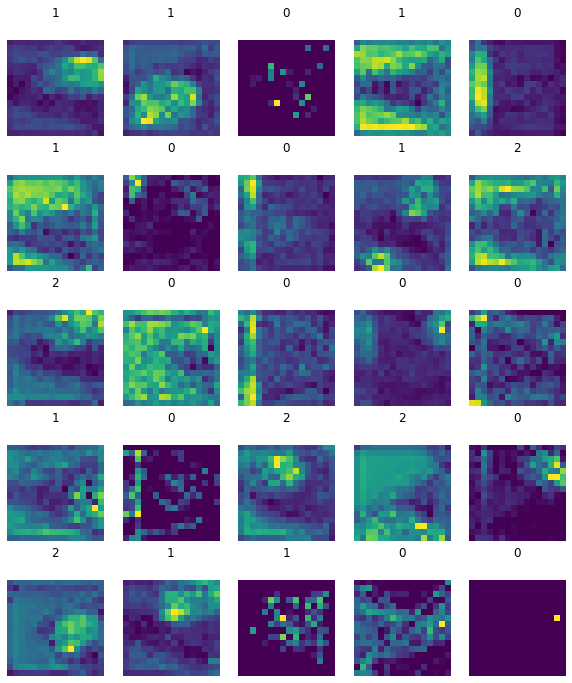

In [15]:
# Gradient-weighted Class Activation Mapping(Grad-Cam)

heatmap_list = []
for x in range(25):
    img = np.reshape(X_test[x], [1, 256, 256, 3]) #(1, 128, 128, 3)
    heatmap = make_gradcam_heatmap(img, model_cnn, "conv2d_9")
    heatmap_list.append(heatmap)

# Display heatmap
fig = plt.figure(figsize=[10, 12])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.matshow(heatmap_list[i])
    ax.set_title(Y_test[i])
    ax.axis('off')
#plt.matshow(heatmap)
#plt.show()

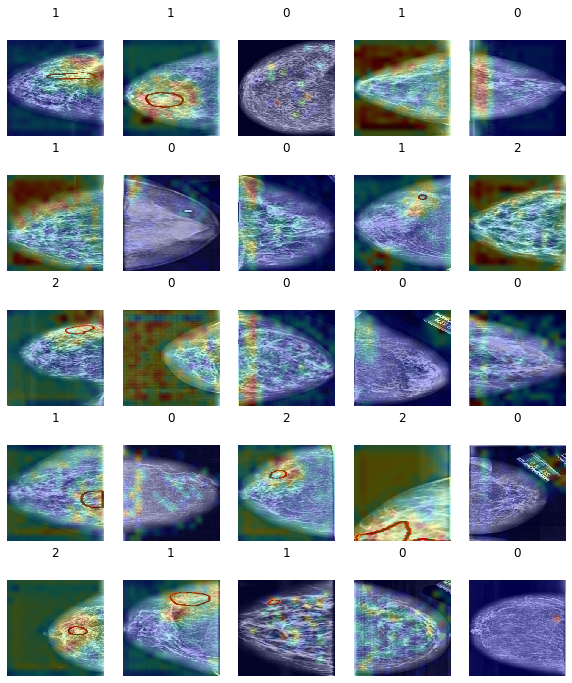

In [17]:
superimposed_img_list = []

for x in range(25):
    img = np.reshape(X_test[x], [1, 256, 256, 3]) #(1, 128, 128, 3)
    heatmap = make_gradcam_heatmap(img, model_cnn, "conv2d_9") #make heatmap
    
    img = np.squeeze(img)
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    superimposed_img_list.append(superimposed_img)
    
fig = plt.figure(figsize=[10, 12])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.matshow(superimposed_img_list[i])
    ax.set_title(Y_test[i])
    ax.axis('off')